In [17]:
# Imports, path setup

import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import numpy as np

import rvt.vis
import rvt.blend
import rvt.default

# Set working directories
CWD = os.getcwd()
DTM_DIRS = {
    "A": os.path.join(CWD, "data", "processed", "dtm", "fnands_openai_optimised_02"),
    "B": os.path.join(CWD, "data", "processed", "dtm", "fnands_openai_optimised_04"),
}
VAT_DIR = os.path.join(CWD, "data", "processed", "vat")  # Lowercase 'vat' to match your directory
METAFILE = os.path.join(CWD, "prefix7_metafile.txt")

PIPELINE_SUFFIX = {
    "A": "_fnands_openai_optimised_02.tif",
    "B": "_fnands_openai_optimised_04.tif"
}

# a = list(DTM_DIRS.values())[:]
# for dir in [a[0], a[1], VAT_DIR]:
#     print(f"{dir}: {os.path.isdir(dir)}")

# print(f"{METAFILE} :{os.path.exists(METAFILE)}")

In [18]:
# Read list of filenames (stripping off '.laz' if present)
with open(METAFILE, "r") as f:
    laz_basenames = [Path(line.strip()).stem for line in f if line.strip()]

print(f"Found {len(laz_basenames)} filenames in metafile.")
if len(laz_basenames) == 0:
    raise RuntimeError("No filenames found in metafile.")

Found 74 filenames in metafile.


In [19]:
# Block 2: Load metadata CSV
METADATA_CSV = os.path.join(CWD, "lidar_metadata_full.csv")
metadata_df = pd.read_csv(METADATA_CSV)

In [93]:
def compute_combined_vat(input_dem_path, output_vat_path, general_opacity, 
                         vat_comb_json, terrain_sett_json, normalize=False):
    """Compute and save VAT Combined float for a single DTM."""
    if os.path.isfile(output_vat_path):
        print(f"{output_vat_path} already exists. Skipping computation.")
        return output_vat_path

    default_1 = rvt.default.DefaultValues()
    default_2 = rvt.default.DefaultValues()
    default_1.fill_no_data = 0
    default_2.fill_no_data = 0
    default_1.keep_original_no_data = 0
    default_2.keep_original_no_data = 0

    vat_comb_1 = rvt.blend.BlenderCombination()
    vat_comb_2 = rvt.blend.BlenderCombination()
    vat_comb_1.read_from_file(vat_comb_json)
    vat_comb_2.read_from_file(vat_comb_json)
    
    terrain_settings = rvt.blend.TerrainsSettings()
    terrain_settings.read_from_file(terrain_sett_json)
    terrain_1 = terrain_settings.select_terrain_settings_by_name("general")
    terrain_2 = terrain_settings.select_terrain_settings_by_name("flat")
    terrain_1.apply_terrain(default=default_1, combination=vat_comb_1)
    terrain_2.apply_terrain(default=default_2, combination=vat_comb_2)
    
    #####
    dict_arr_res_nd = rvt.default.get_raster_arr(raster_path=input_dem_path)

    if normalize:
        # Prepare normalized DTM
        dtm = dict_arr_res_nd["array"].astype(float)
        finite = dtm[np.isfinite(dtm)]
        lower, upper = np.percentile(finite, [2, 98])
        dtm = np.clip(dtm, lower, upper)
        dtm = (dtm - lower) / (upper - lower)
        # preserve nodata
        if "no_data" in dict_arr_res_nd and dict_arr_res_nd["no_data"] is not None:
            dtm[dict_arr_res_nd["array"] == dict_arr_res_nd["no_data"]] = np.nan
        dem_to_use = dtm
        print(f"Applied percentile normalization ({lower:.2f} - {upper:.2f}) to DTM: {input_dem_path}")
    else:
        # Use the raw DTM array
        dem_to_use = dict_arr_res_nd["array"]

    vat_comb_1.add_dem_arr(dem_arr=dem_to_use, dem_resolution=dict_arr_res_nd["resolution"][0])
    vat_arr_1 = vat_comb_1.render_all_images(default=default_1, no_data=dict_arr_res_nd["no_data"])
    vat_comb_2.add_dem_arr(dem_arr=dem_to_use, dem_resolution=dict_arr_res_nd["resolution"][0])
    vat_arr_2 = vat_comb_2.render_all_images(default=default_2, no_data=dict_arr_res_nd["no_data"])
    #####

    combination = rvt.blend.BlenderCombination()
    combination.create_layer(
        vis_method="VAT general", image=vat_arr_1, normalization="Value",
        minimum=0, maximum=1, blend_mode="Normal", opacity=general_opacity
    )
    combination.create_layer(
        vis_method="VAT flat", image=vat_arr_2, normalization="Value",
        minimum=0, maximum=1, blend_mode="Normal", opacity=100
    )
    combination.add_dem_path(dem_path=input_dem_path)
    combination.render_all_images(
        save_render_path=output_vat_path, save_visualizations=False, 
        save_float=True, save_8bit=False,
        no_data=dict_arr_res_nd["no_data"]
    )
    print(f"VAT Combined saved to {output_vat_path}")
    return output_vat_path

In [94]:
# Block 4: Visualisation function

# Utility: read vat raster as float (with np.nan for nodata)
def read_vat_float_image(vat_path):
    with rasterio.open(vat_path) as src:
        arr = src.read(1).astype(float)
        # Replace nodata by np.nan
        no_data = src.nodatavals[0]
        if no_data is not None:
            arr[arr == no_data] = np.nan
        return arr
    
def plot_vat_pair_with_density(
    fname, 
    dtm_dirs=DTM_DIRS, 
    suffix=PIPELINE_SUFFIX, 
    vat_dir=VAT_DIR, 
    metadata_df=metadata_df, 
    show_titles=True
):
    """Show A/B VATs for fname, with density annotation."""
    # DTM and VAT paths
    dtm_paths = {}
    vat_paths = {}
    for label in ["A", "B"]:
        dtm_fname = f"{fname}{suffix[label]}"
        dtm_path = os.path.join(dtm_dirs[label], dtm_fname)
        dtm_paths[label] = dtm_path
        vat_fname = dtm_fname.replace(".tif", "_VAT_Combined.tif")
        vat_path = os.path.join(vat_dir, vat_fname)
        vat_paths[label] = vat_path

    # Get ground point density
    csv_name = f"{fname}.laz"
    row = metadata_df[metadata_df['filename'] == csv_name]
    if row.empty:
        ground_density = None
    else:
        ground_density = float(row.iloc[0]['density_ground_per_m2'])

    # Read images
    for label in ["A", "B"]:
        if not os.path.isfile(vat_paths[label]):
            print(f"ERROR: Missing VAT file for {label}: {vat_paths[label]}")
            return
    vat_a = read_vat_float_image(vat_paths["A"])
    vat_b = read_vat_float_image(vat_paths["B"])

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    vmin = np.nanmin([vat_a, vat_b])
    vmax = np.nanmax([vat_a, vat_b])
    titles = [
        f"{fname} | pipeline A | density_ground_per_m2={ground_density:.3f}" if ground_density is not None else f"{fname} | pipeline A",
        f"{fname} | pipeline B | density_ground_per_m2={ground_density:.3f}" if ground_density is not None else f"{fname} | pipeline B"
    ]
    for i, (arr, ax) in enumerate(zip([vat_a, vat_b], axes)):
        im = ax.imshow(arr, cmap='gray', vmin=vmin, vmax=vmax)
        if show_titles:
            ax.set_title(titles[i], fontsize=14)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [95]:
def process_and_plot_vat_pair_by_index(
    index,
    laz_basenames=laz_basenames,
    dtm_dirs=DTM_DIRS,
    pipeline_suffix=PIPELINE_SUFFIX,
    vat_dir=VAT_DIR,
    general_opacity=GENERAL_OPACITY,
    vat_comb_json=VAT_COMB_JSON,
    terrain_sett_json=TERRAIN_SETT_JSON,
    metadata_df=metadata_df):
    """
    For a given index in laz_basenames:
      - Ensure both A and B VAT Combined images are generated (if needed)
      - Then plot as a side-by-side panel with ground density
    """
    if index >= len(laz_basenames) or index < 0:
        print(f"ERROR: Index {index} out of range.")
        return
    fname = laz_basenames[index]
    # Prepare DTM and VAT paths
    dtm_paths = {}
    vat_paths = {}
    for label in ['A', 'B']:
        dtm_fname = f"{fname}{pipeline_suffix[label]}"
        dtm_path = os.path.join(dtm_dirs[label], dtm_fname)
        vat_fname = dtm_fname.replace('.tif', '_VAT_Combined.tif')
        vat_path = os.path.join(vat_dir, vat_fname)
        dtm_paths[label] = dtm_path
        vat_paths[label] = vat_path

    # Create VAT if missing (for both)
    for label in ['A', 'B']:
        if not os.path.isfile(vat_paths[label]):
            if os.path.isfile(dtm_paths[label]):
                print(f"Computing VAT Combined for {fname} [{label}] ...")
                compute_combined_vat(
                    input_dem_path=dtm_paths[label],
                    output_vat_path=vat_paths[label],
                    general_opacity=general_opacity,
                    vat_comb_json=vat_comb_json,
                    terrain_sett_json=terrain_sett_json)
            else:
                print(f"ERROR: DTM missing for {fname} [{label}]: {dtm_paths[label]}")
    # Plot (if possible)
    # plot_vat_pair_with_density(fname,
    #                           dtm_dirs=dtm_dirs,
    #                           suffix=pipeline_suffix,
    #                           vat_dir=vat_dir,
    #                           metadata_df=metadata_df)



In [96]:
index = -1

In [97]:
# Example usage – step through with:
index +=1  # or whatever index you want
for index in range(100):
    print(index)
    process_and_plot_vat_pair_by_index(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
ERROR: DTM missing for cms_brazil_lidar_tile_inventory [A]: /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/dtm/fnands_openai_optimised_02/cms_brazil_lidar_tile_inventory_fnands_openai_optimised_02.tif
ERROR: DTM missing for cms_brazil_lidar_tile_inventory [B]: /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/dtm/fnands_openai_optimised_04/cms_brazil_lidar_tile_inventory_fnands_openai_optimised_04.tif
68
69
70
71
72
73
74
ERROR: Index 74 out of range.
75
ERROR: Index 75 out of range.
76
ERROR: Index 76 out of range.
77
ERROR: Index 77 out of range.
78
ERROR: Index 78 out of range.
79
ERROR: Index 79 out of range.
80
ERROR: Index 80 out of range.
81
ERROR: Index 81 out of range.
82
ERROR: Index 82 out of range.
83
ERROR: Index 83 out of range.
84
ERROR: Index 84 out

In [98]:
def process_and_plot_arbitrary_fname(
    fname,
    dtm_dirs=DTM_DIRS,
    pipeline_suffix=PIPELINE_SUFFIX,
    vat_dir=VAT_DIR,
    general_opacity=GENERAL_OPACITY,
    vat_comb_json=VAT_COMB_JSON,
    terrain_sett_json=TERRAIN_SETT_JSON,
    metadata_df=metadata_df,
    show_titles=True
):
    """
    Process and plot a specific FILENAME (w/o .tif or .laz).
    Looks for VAT Combined in both A and B folders, computes if missing,
    and plots side by side.
    """
    # Build DTM and VAT paths
    dtm_paths = {}
    vat_paths = {}
    for label in ['A', 'B']:
        dtm_fname = f"{fname}{pipeline_suffix[label]}"
        dtm_path = os.path.join(dtm_dirs[label], dtm_fname)
        vat_fname = dtm_fname.replace('.tif', '_VAT_Combined.tif')
        vat_path = os.path.join(vat_dir, vat_fname)
        dtm_paths[label] = dtm_path
        vat_paths[label] = vat_path

    # Create VAT if missing (for both)
    for label in ['A', 'B']:
        if not os.path.isfile(vat_paths[label]):
            if os.path.isfile(dtm_paths[label]):
                print(f"Computing VAT Combined for {fname} [{label}] ...")
                compute_combined_vat(
                    input_dem_path=dtm_paths[label],
                    output_vat_path=vat_paths[label],
                    general_opacity=general_opacity,
                    vat_comb_json=vat_comb_json,
                    terrain_sett_json=terrain_sett_json)
            else:
                print(f"ERROR: DTM missing for {fname} [{label}]: {dtm_paths[label]}")
    # Try to extract ground density if possible
    csv_name = f"{fname}.laz"
    if "density_ground_per_m2" in metadata_df.columns:
        row = metadata_df[metadata_df['filename'] == csv_name]
        ground_density = float(row.iloc[0]['density_ground_per_m2']) if not row.empty else None
    else:
        ground_density = None

    # Read and plot VATs
    for label in ["A", "B"]:
        if not os.path.isfile(vat_paths[label]):
            print(f"ERROR: Missing VAT file for {label}: {vat_paths[label]}")
            return
    vat_a = read_vat_float_image(vat_paths["A"])
    vat_b = read_vat_float_image(vat_paths["B"])

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    vmin = np.nanmin([vat_a, vat_b])
    vmax = np.nanmax([vat_a, vat_b])
    titles = [
        f"{fname} | pipeline A | density_ground_per_m2={ground_density:.3f}" if ground_density is not None else f"{fname} | pipeline A",
        f"{fname} | pipeline B | density_ground_per_m2={ground_density:.3f}" if ground_density is not None else f"{fname} | pipeline B"
    ]
    for i, (arr, ax) in enumerate(zip([vat_a, vat_b], axes)):
        im = ax.imshow(arr, cmap='gray', vmin=vmin, vmax=vmax)
        if show_titles:
            ax.set_title(titles[i], fontsize=14)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [99]:
## FILES OF INTEREST

fois = [
    "BON_A01_2013_laz_13",
    "BON_A01_2018_LAS_11",
    "RIB_A01_2014_laz_2",
    "RIB_A01_2018_LAS_11"
]

Computing VAT Combined for BON_A01_2013_laz_13 [A] ...
VAT Combined saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/BON_A01_2013_laz_13_fnands_openai_optimised_02_VAT_Combined.tif
Computing VAT Combined for BON_A01_2013_laz_13 [B] ...
VAT Combined saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/BON_A01_2013_laz_13_fnands_openai_optimised_04_VAT_Combined.tif


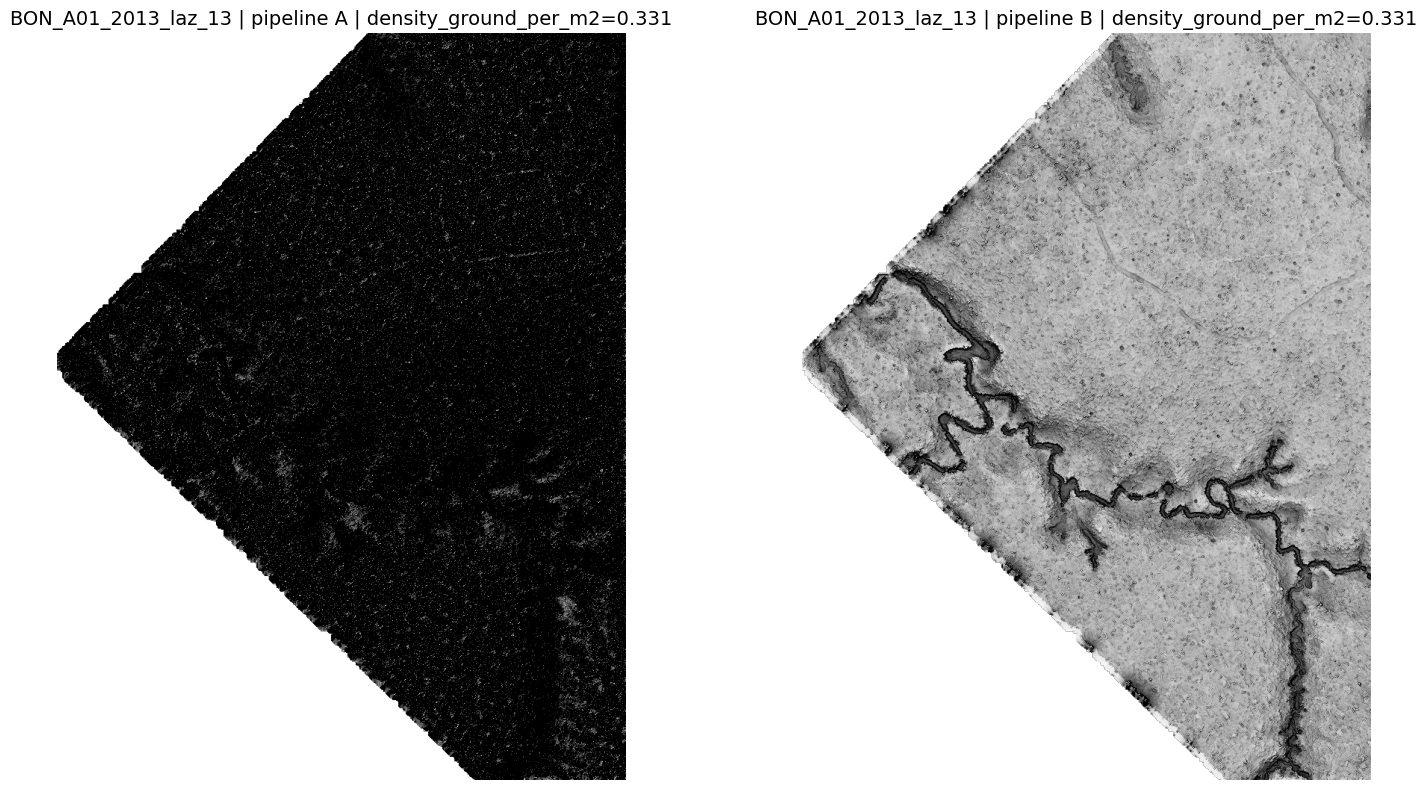

Computing VAT Combined for BON_A01_2018_LAS_11 [A] ...
VAT Combined saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/BON_A01_2018_LAS_11_fnands_openai_optimised_02_VAT_Combined.tif
Computing VAT Combined for BON_A01_2018_LAS_11 [B] ...
VAT Combined saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/BON_A01_2018_LAS_11_fnands_openai_optimised_04_VAT_Combined.tif


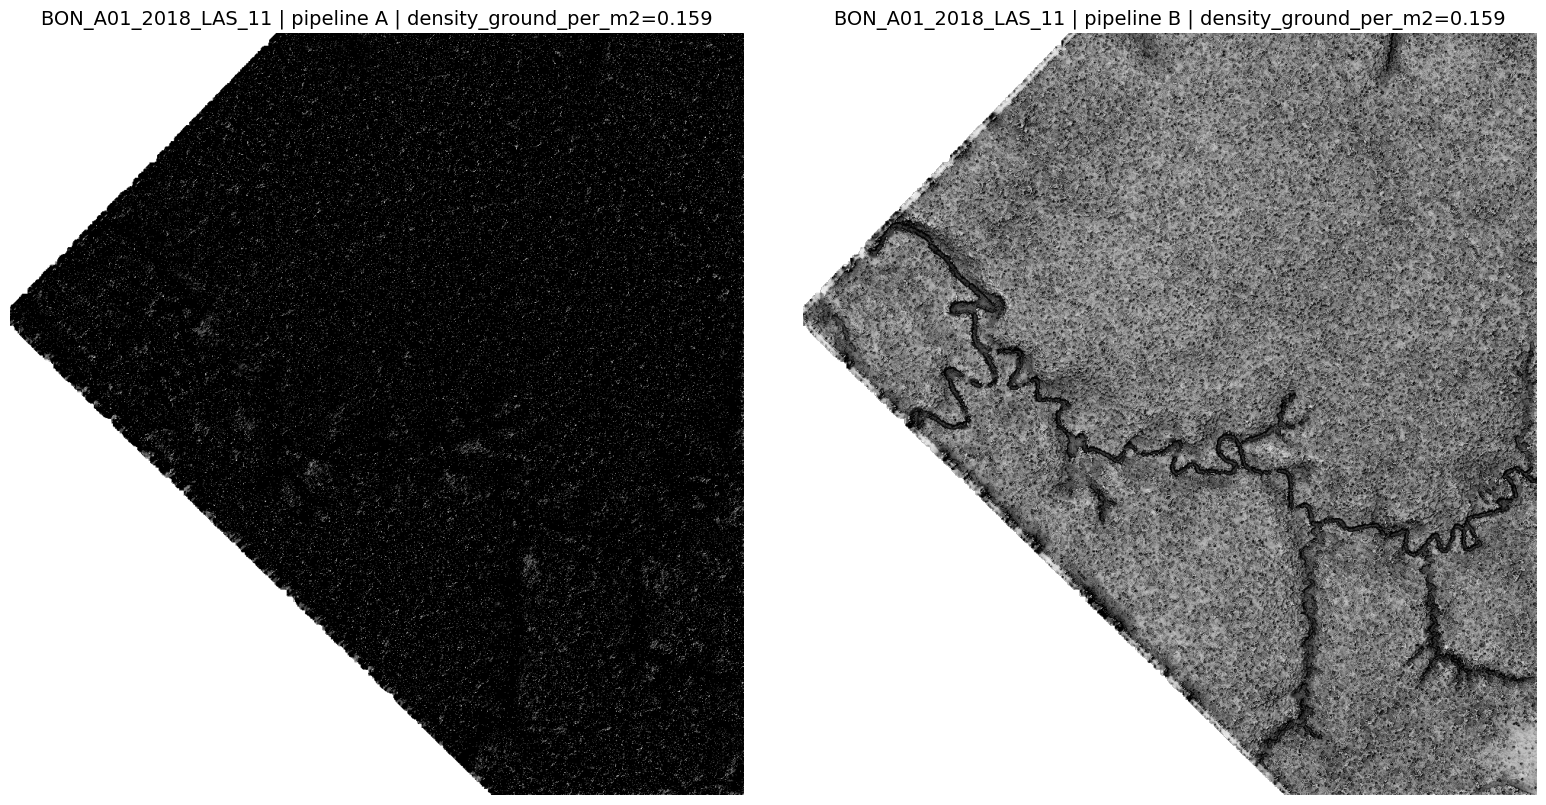

Computing VAT Combined for RIB_A01_2014_laz_2 [A] ...
VAT Combined saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/RIB_A01_2014_laz_2_fnands_openai_optimised_02_VAT_Combined.tif
Computing VAT Combined for RIB_A01_2014_laz_2 [B] ...
VAT Combined saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/RIB_A01_2014_laz_2_fnands_openai_optimised_04_VAT_Combined.tif


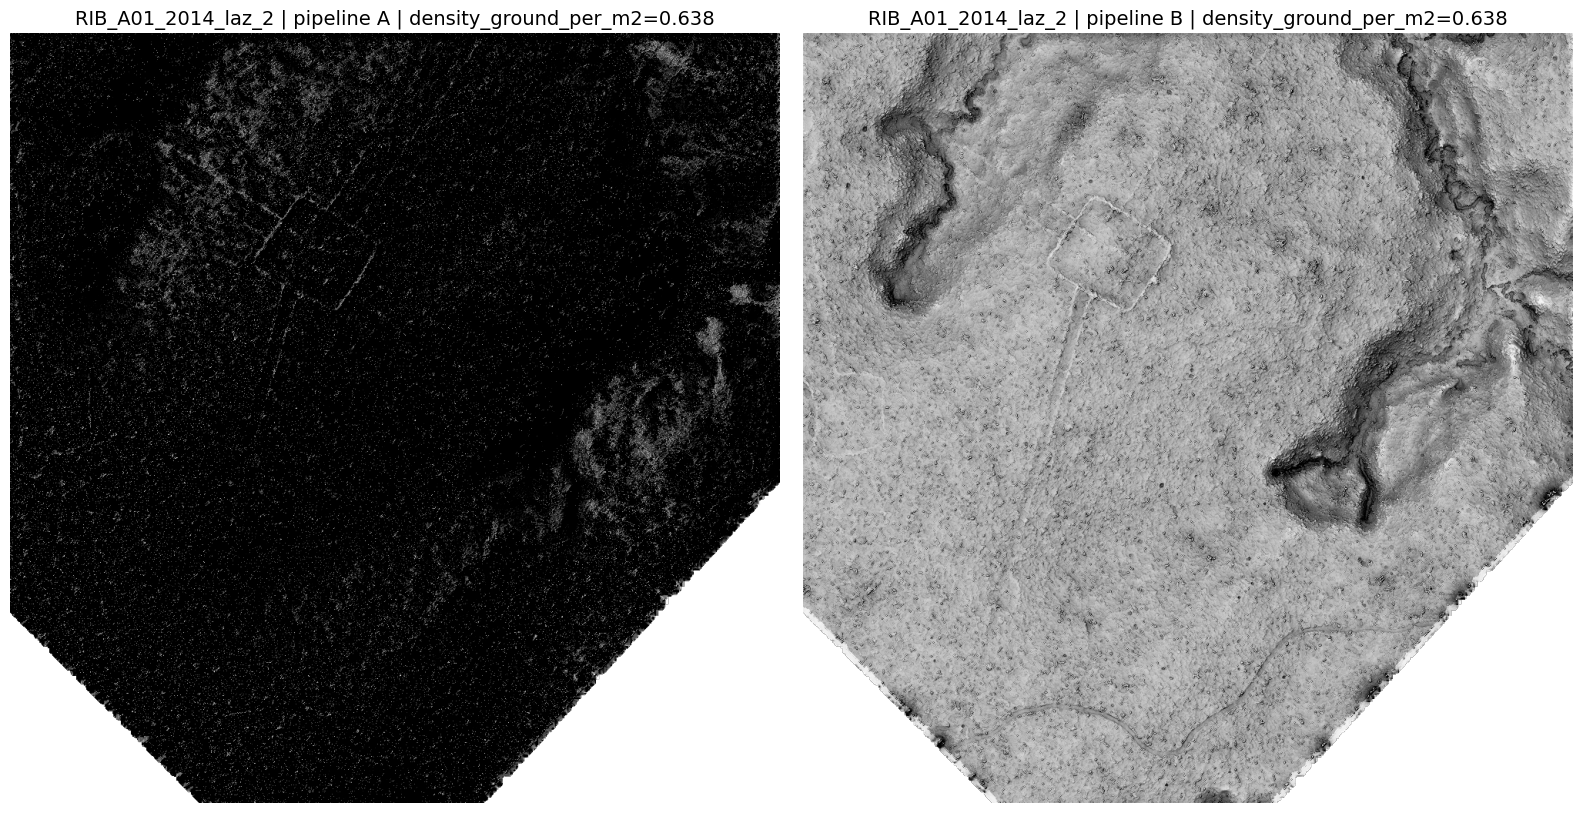

Computing VAT Combined for RIB_A01_2018_LAS_11 [A] ...
VAT Combined saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/RIB_A01_2018_LAS_11_fnands_openai_optimised_02_VAT_Combined.tif
Computing VAT Combined for RIB_A01_2018_LAS_11 [B] ...
VAT Combined saved to /Users/jamesbyers/code/github/Kaggle/openai_to_z/data/processed/vat/RIB_A01_2018_LAS_11_fnands_openai_optimised_04_VAT_Combined.tif


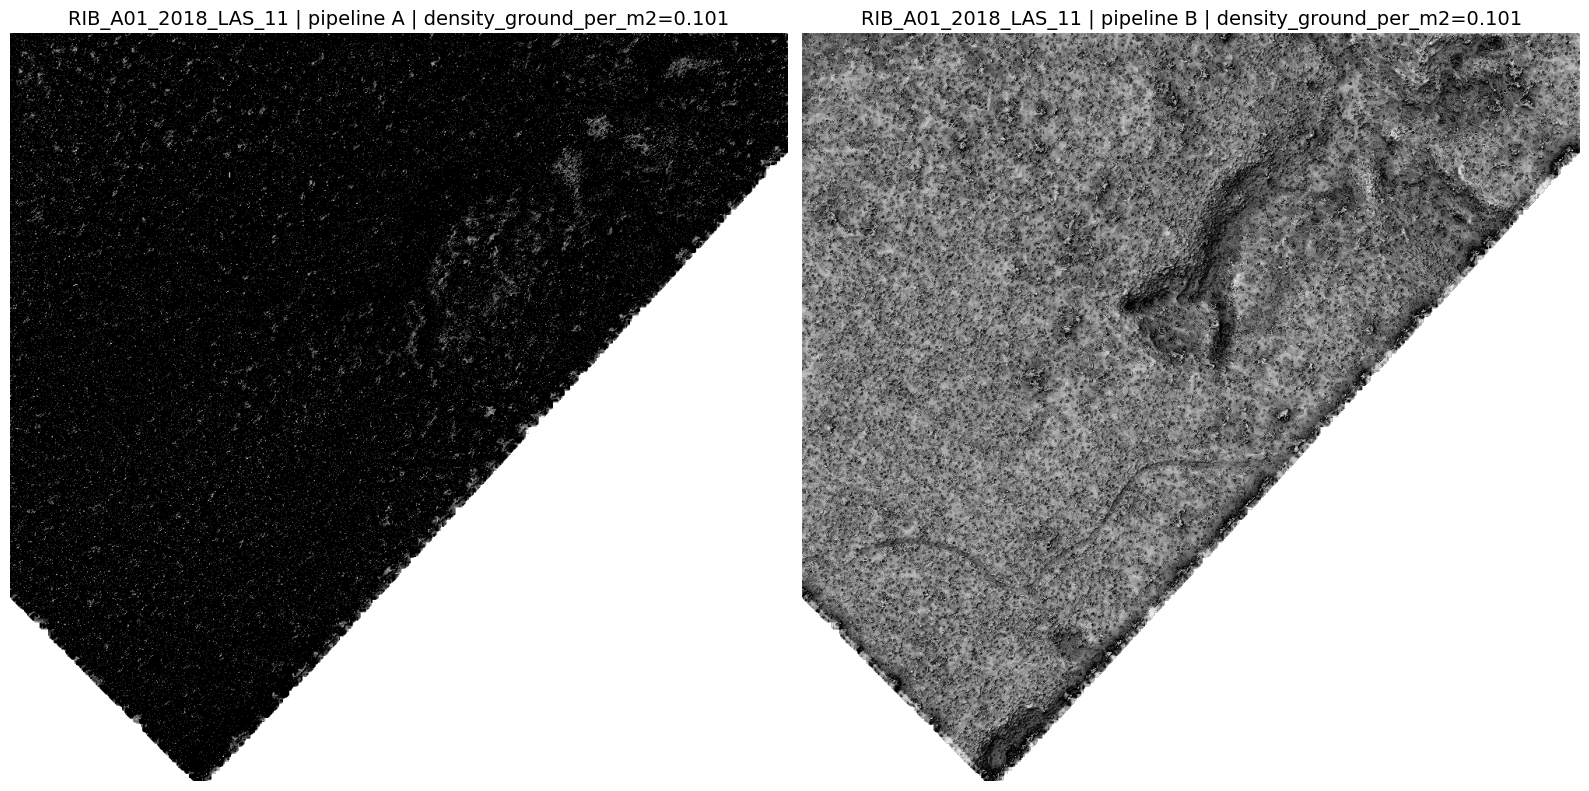

In [100]:
for fname in fois:
    process_and_plot_arbitrary_fname(fname)

In [101]:
def plot_raw_dtm_pair(
    fname,
    dtm_dirs=DTM_DIRS,
    suffix=PIPELINE_SUFFIX,
    metadata_df=metadata_df,
    show_titles=True,
    cmap='terrain'
):
    """
    Plot the *raw* DTM rasters (not VATs) for pipeline A and B side by side.
    """
    # Set up DTM paths
    dtm_paths = {}
    for label in ["A", "B"]:
        dtm_fname = f"{fname}{suffix[label]}"
        dtm_path = os.path.join(dtm_dirs[label], dtm_fname)
        dtm_paths[label] = dtm_path

    # Load arrays and handle missing
    dtm_arrays = {}
    for label in ["A", "B"]:
        if not os.path.isfile(dtm_paths[label]):
            print(f"ERROR: Missing DTM file for {label}: {dtm_paths[label]}")
            return
        with rasterio.open(dtm_paths[label]) as src:
            arr = src.read(1).astype(float)
            no_data = src.nodatavals[0]
            if no_data is not None:
                arr[arr == no_data] = np.nan
            dtm_arrays[label] = arr

    # Prepare titles
    csv_name = f"{fname}.laz"
    row = metadata_df[metadata_df['filename'] == csv_name]
    if row.empty:
        ground_density = None
    else:
        ground_density = float(row.iloc[0]['density_ground_per_m2'])
    titles = [
        f"{fname} | pipeline A | density_ground_per_m2={ground_density:.3f}" if ground_density is not None else f"{fname} | pipeline A",
        f"{fname} | pipeline B | density_ground_per_m2={ground_density:.3f}" if ground_density is not None else f"{fname} | pipeline B"
    ]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    all_data = np.concatenate([dtm_arrays["A"].flatten(), dtm_arrays["B"].flatten()])
    vmin = np.nanmin(all_data)
    vmax = np.nanmax(all_data)
    for i, label in enumerate(["A", "B"]):
        im = axes[i].imshow(dtm_arrays[label], cmap=cmap, vmin=vmin, vmax=vmax)
        if show_titles:
            axes[i].set_title(titles[i], fontsize=14)
        axes[i].axis('off')
    plt.tight_layout()
    plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    plt.show()

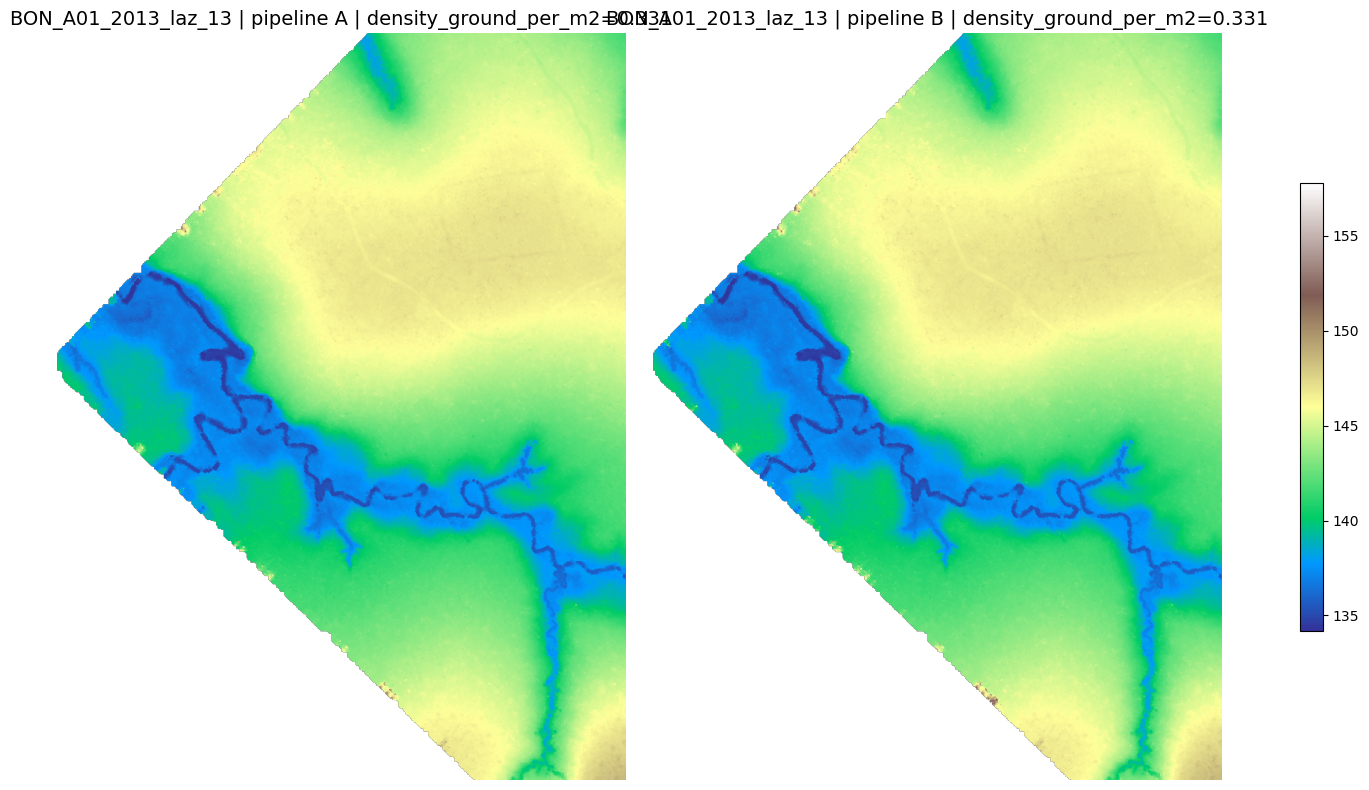

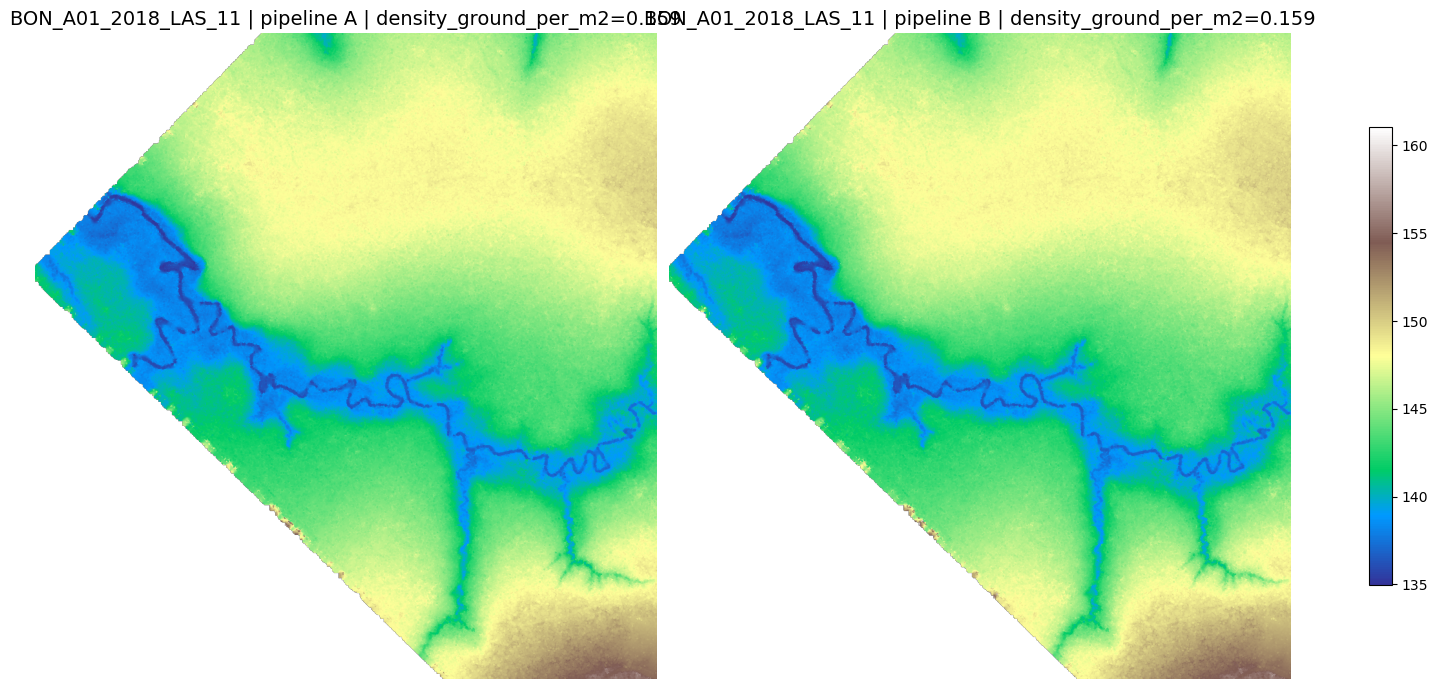

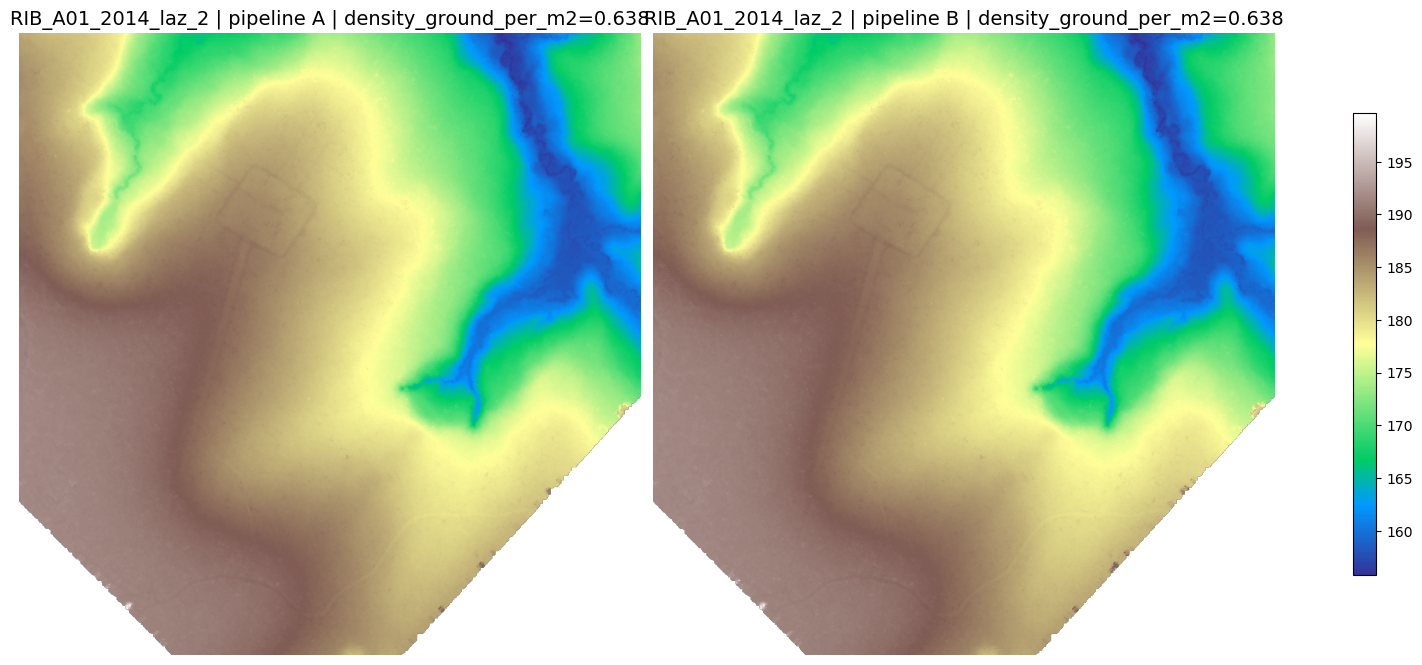

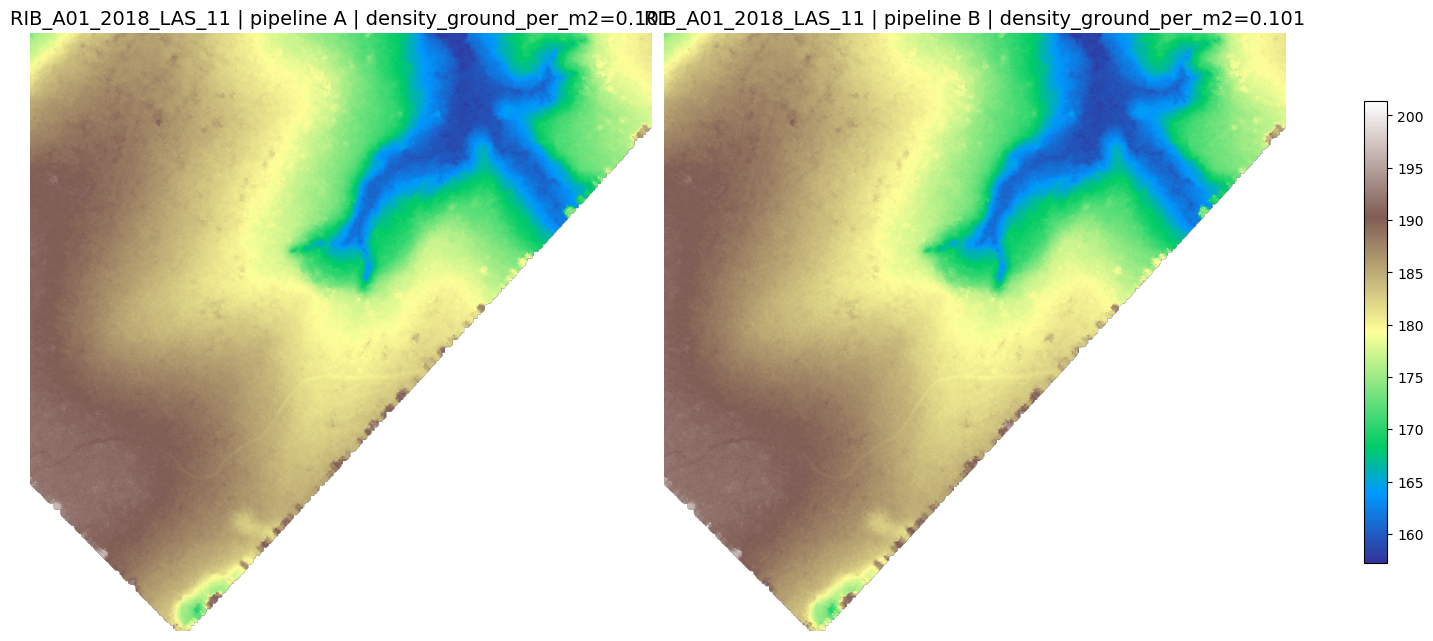

In [102]:
for fname in fois:
    plot_raw_dtm_pair(fname)